## Add necessary functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from tqdm import tqdm
import os
import sys
import math

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")



There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
from torch.nn.utils import spectral_norm



In [3]:
def pgen_log(pgen_val):
    if pgen_val < 1e-20:
        pgen_val += 1e-20
    return round(math.log10(pgen_val), 5)

In [4]:
def encode_seq(seq):
    mtr = np.zeros((10, len(seq), 20))
    for factor in range(10):
        for aa_i in range(len(seq)):
            mtr[factor, aa_i, list(aa_inds[f'f{factor+1}']).index(seq[aa_i])] = 1
        
    return mtr#.shape


In [5]:
# Utils functions for GPU usage of neural networks
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
class SoftExponential(nn.Module):
    def __init__(self, alpha=-0.5, beta=1000.0):
        super(SoftExponential, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.beta = nn.Parameter(torch.tensor(beta))

    def forward(self, x):
        if self.alpha.item() < 0:
            return -1.0 * self.beta / self.alpha * (torch.exp(-self.alpha * x) - 1)
        elif self.alpha.item() == 0:
            return x * self.beta
        else:
            return 1.0 * self.beta / self.alpha * (torch.exp(self.alpha * x) - 1)


In [7]:
import torch.nn.functional as F


In [8]:
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(parent_dir)
sys.path.append(os.path.abspath(os.path.join(parent_dir, '..')))

In [9]:
sys.path.append(os.path.join('/home/akabalina', 'OLGA/olga'))
# sys.path

In [10]:
import olga.load_model as load_model
import olga.generation_probability as pgen
params_file_name = '/home/akabalina/OLGA/olga/default_models/human_T_beta/model_params.txt'
marginals_file_name = '/home/akabalina/OLGA/olga/default_models/human_T_beta/model_marginals.txt'
V_anchor_pos_file ='/home/akabalina/OLGA/olga/default_models/human_T_beta/V_gene_CDR3_anchors.csv'
J_anchor_pos_file = '/home/akabalina/OLGA/olga/default_models/human_T_beta/J_gene_CDR3_anchors.csv'
genomic_data = load_model.GenomicDataVDJ()
genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)

generative_model = load_model.GenerativeModelVDJ()
generative_model.load_and_process_igor_model(marginals_file_name)

pgen_model = pgen.GenerationProbabilityVDJ(generative_model, genomic_data)

In [11]:
### kidera factors

In [12]:
kidera = pd.DataFrame.from_records(list(map(lambda x: list(map(float, x.split(','))), "-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.2,-0.08,0.21,-0.48;0.22,1.27,1.37,1.87,-1.7,0.46,0.92,-0.39,0.23,0.93;1.14,-0.07,-0.12,0.81,0.18,0.37,-0.09,1.23,1.1,-1.73;0.58,-0.22,-1.58,0.81,-0.92,0.15,-1.52,0.47,0.76,0.7;0.12,-0.89,0.45,-1.05,-0.71,2.41,1.52,-0.69,1.13,1.1;-0.47,0.24,0.07,1.1,1.1,0.59,0.84,-0.71,-0.03,-2.33;-1.45,0.19,-1.61,1.17,-1.31,0.4,0.04,0.38,-0.35,-0.12;1.46,-1.96,-0.23,-0.16,0.1,-0.11,1.32,2.36,-1.66,0.46;-0.41,0.52,-0.28,0.28,1.61,1.01,-1.85,0.47,1.13,1.63;-0.73,-0.16,1.79,-0.77,-0.54,0.03,-0.83,0.51,0.66,-1.78;-1.04,0,-0.24,-1.1,-0.55,-2.05,0.96,-0.76,0.45,0.93;-0.34,0.82,-0.23,1.7,1.54,-1.62,1.15,-0.08,-0.48,0.6;-1.4,0.18,-0.42,-0.73,2,1.52,0.26,0.11,-1.27,0.27;-0.21,0.98,-0.36,-1.43,0.22,-0.81,0.67,1.1,1.71,-0.44;2.06,-0.33,-1.15,-0.75,0.88,-0.45,0.3,-2.3,0.74,-0.28;0.81,-1.08,0.16,0.42,-0.21,-0.43,-1.89,-1.15,-0.97,-0.23;0.26,-0.7,1.21,0.63,-0.1,0.21,0.24,-1.15,-0.56,0.19;0.3,2.1,-0.72,-1.57,-1.16,0.57,-0.48,-0.4,-2.3,-0.6;1.38,1.48,0.8,-0.56,0,-0.68,-0.31,1.03,-0.05,0.53;-0.74,-0.71,2.04,-0.4,0.5,-0.81,-1.07,0.06,-0.46,0.65".split(";"))), index=["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"], columns=list(map(lambda x: "f"+str(x), range(1,11))))
# https://github.com/vadimnazarov/kidera-atchley?tab=readme-ov-file

aa_inds = pd.DataFrame(columns=kidera.columns, index = range(0,20))
for i in range(10):
    curr_kidera = kidera.columns[i]
    aa_inds[curr_kidera] = kidera[curr_kidera].sort_values().index.values


In [13]:
def decode_seq(pred, aa_inds=aa_inds):
    pred = pred.argmax(dim=2)
    pred_seqs = []
    
    for i in range(pred.shape[0]):
        curr_code = aa_inds[f'f{i+1}']
        curr_seq = pred[i].tolist()
        # print('')
        dec_seq = []
        for j in range(15):
            # print(curr_seq[j])
            # print('')

            dec_seq.append(curr_code.loc[curr_seq[j]])
        dec_seq = ''.join(dec_seq)
        pgen = pgen_model.compute_aa_CDR3_pgen(dec_seq)
        pred_seqs.append((''.join(dec_seq), pgen_log(pgen)))
    
    pred_seqs.sort(key = lambda x: x[1], reverse=True)

    return pred_seqs[0]

In [14]:
# seqs_df = pd.read_csv('covid_data_seqs_pgen.csv')
# # seqs_df['seq_enc'] = seqs_df['cdr3aa'].apply(encode_seq)

# # seqs_df


In [15]:
# train_ds = torch.tensor(seqs_df['seq_enc'].tolist(), dtype=torch.float32)
# train_ps = torch.tensor(seqs_df['pgen_log'].tolist(), dtype=torch.float32)

# train_ds.shape


In [16]:
# Create PyTorch DataLoader object to produce batches
# batch_size = 32
batch_size = 64
latent_size = 32
# train_dl = DataLoader(train_ds, batch_size, shuffle=False, pin_memory=True)
# train_pl = DataLoader(train_ps, batch_size, shuffle=False, pin_memory=True)

### Get checkpoints


In [17]:
def get_trained_model(checkpoint_path):
    discriminator = nn.Sequential(
        spectral_norm(nn.Conv2d(10, 32, kernel_size=3, stride=1, padding=1, bias=False)),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, inplace=True),

        spectral_norm(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False)),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        spectral_norm(nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1, bias=False)),

        nn.Flatten(),
        nn.Linear(15, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
        SoftExponential())
    
    generator = nn.Sequential(
        nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Dropout(0.3),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Dropout(0.3),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Dropout(0.3),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 10, kernel_size=(4, 5), stride=(1, 1), padding=(10, 8), bias=False),
        nn.Tanh())
    
    checkpoint = torch.load(checkpoint_path)

    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    device = get_default_device()
    
    generator = to_device(generator, device)
    discriminator = to_device(discriminator, device)
    
    return discriminator, generator

In [18]:
# base model
checkpoint_path = 'logs/gan/20250522-040142/checkpoints/epoch_19.pth'
discriminator, generator = get_trained_model(checkpoint_path)

In [19]:
# fine tuned
checkpoint_path_c = 'logs/gan/covid_diploma/20250522-182104/checkpoints/epoch_23.pth'
discriminator_c, generator_c = get_trained_model(checkpoint_path_c)

In [20]:
df_olga = pd.read_csv('../data/olga_300.csv', usecols=['b_cdr3aa', 'pgen_log'], low_memory=False).sample(n=500)
df_real = pd.read_csv('../data/covid_data_seqs_pgen.csv', usecols=['cdr3aa', 'pgen_log'], low_memory=False).sample(n=1500)

## Exploring the latent space

### Discriminator


In [21]:
discriminator.eval()
generator.eval()

discriminator_c.eval()
generator_c.eval()

Sequential(
  (0): ConvTranspose2d(32, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.3, inplace=False)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): ConvTranspose2d(64, 10, kernel_size=(4, 5),

In [22]:
seqs_df = df_real.copy()
seqs_df['seq_enc'] = seqs_df['cdr3aa'].apply(encode_seq)


In [23]:
seqs_df.reset_index(drop=True, inplace=True)

In [24]:
import random

In [25]:
real_imgs = torch.FloatTensor(seqs_df.seq_enc)
# seqs_df['seq_enc'] = seqs_df['cdr3aa'].apply(encode_seq)
labels = discriminator_c(real_imgs.to(device)).cpu().detach().numpy()

/scratch/ipykernel_2255930/3939551431.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  real_imgs = torch.FloatTensor(seqs_df.seq_enc)


In [26]:
feature_extractor = torch.nn.Sequential(*list(discriminator_c.children())[:-3])


In [27]:
from sklearn.manifold import TSNE

# real_imgs = torch.randn(1000, 10, 15, 20)

real_imgs = real_imgs.to(device)
discriminator_c = to_device(discriminator_c, device)

with torch.no_grad():
    latent_vectors = feature_extractor(real_imgs).cpu().numpy()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


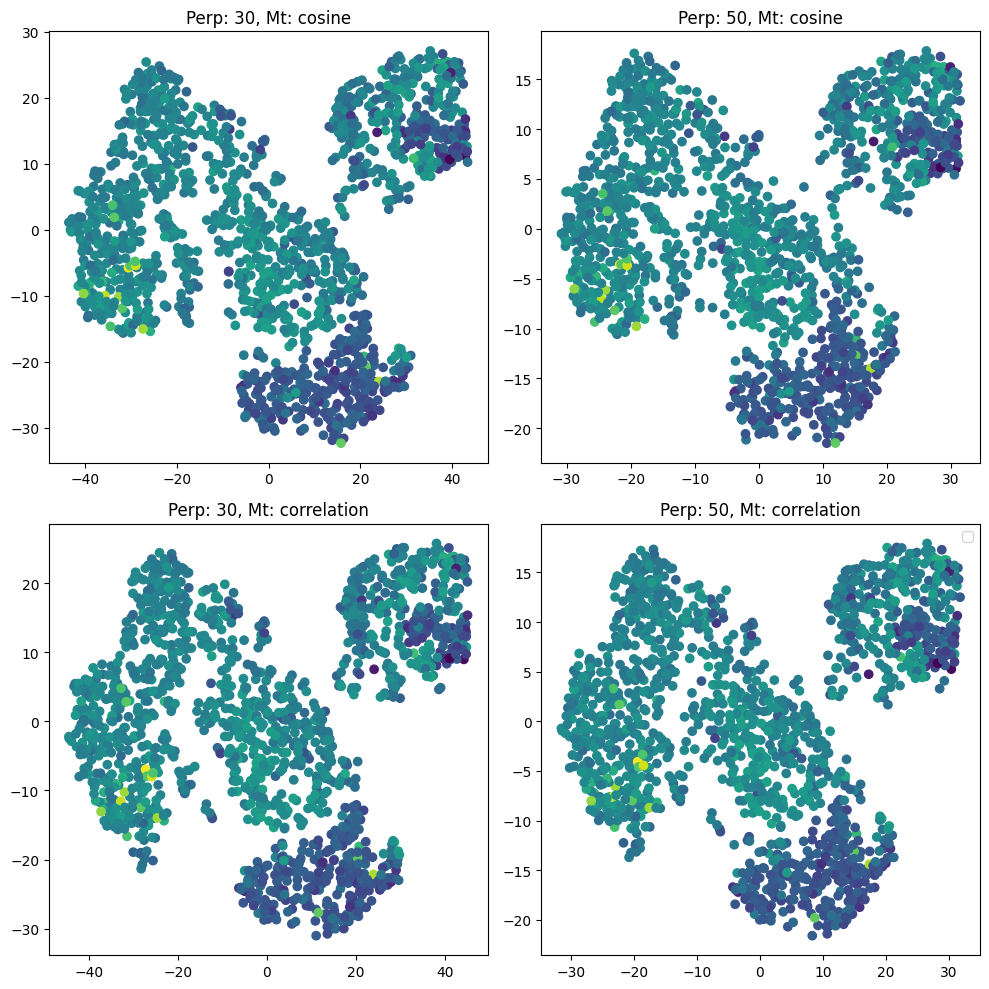

In [28]:
perplexities = [30, 50]
metrics = ['cosine', 'correlation']


fig, axes = plt.subplots(len(metrics), len(perplexities), figsize=(10, 10))

for i, perp in enumerate(perplexities):
    for j, metr in enumerate(metrics):
        tsne = TSNE(n_components=2, perplexity=perp, metric = metr, random_state=42)
        reduced = tsne.fit_transform(latent_vectors)
        
        ax = axes[ j, i]
        ax.scatter(reduced[:, 0], reduced[:, 1], c=labels)
        ax.set_title(f"Perp: {perp}, Mt: {metr}")

plt.tight_layout()
plt.legend()
plt.show()


In [29]:
fake_images = []
generator_c = to_device(generator_c, device)
for i in range(30):
    latent = torch.rand(batch_size, latent_size, 1, 1, device=device) * 2 - 1
    fake_images.extend(generator_c(latent).cpu().detach().numpy())
    
fake_images = torch.FloatTensor(fake_images)
fake_images.shape


torch.Size([1920, 10, 15, 20])

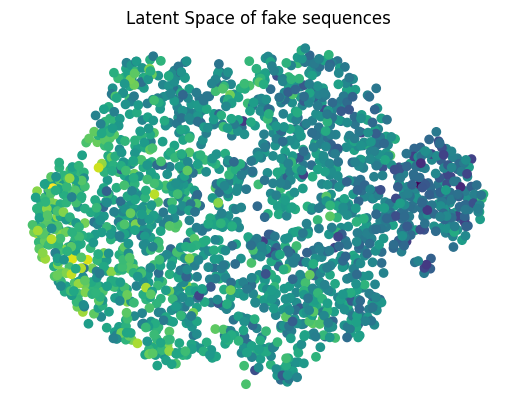

In [30]:
fake_images = fake_images.to(device)

with torch.no_grad():
    latent_vectors = feature_extractor(fake_images).cpu().numpy()
    labels = discriminator_c(fake_images).cpu().detach().numpy()

reduced = TSNE(n_components=2, perplexity=50, metric = 'correlation', random_state=42).fit_transform(latent_vectors)

plt.scatter(reduced[:, 0], reduced[:, 1], c = labels)
plt.axis('off')
plt.title("Latent Space of fake sequences")
plt.show()


In [31]:
fake_images = fake_images.to(device)

with torch.no_grad():
    latent_vectors = feature_extractor(real_imgs).cpu().numpy()
    latent_vectors_fake = feature_extractor(fake_images).cpu().numpy()
    labels_fake = discriminator_c(fake_images).cpu().detach().numpy()
    labels = discriminator_c(real_imgs).cpu().detach().numpy()

tsne = TSNE(n_components=2, perplexity=50, metric = 'correlation', random_state=42)
reduced = tsne.fit_transform(np.vstack((latent_vectors, latent_vectors_fake)))
# reduced2 = tsne.transform(latent_vectors_fake)





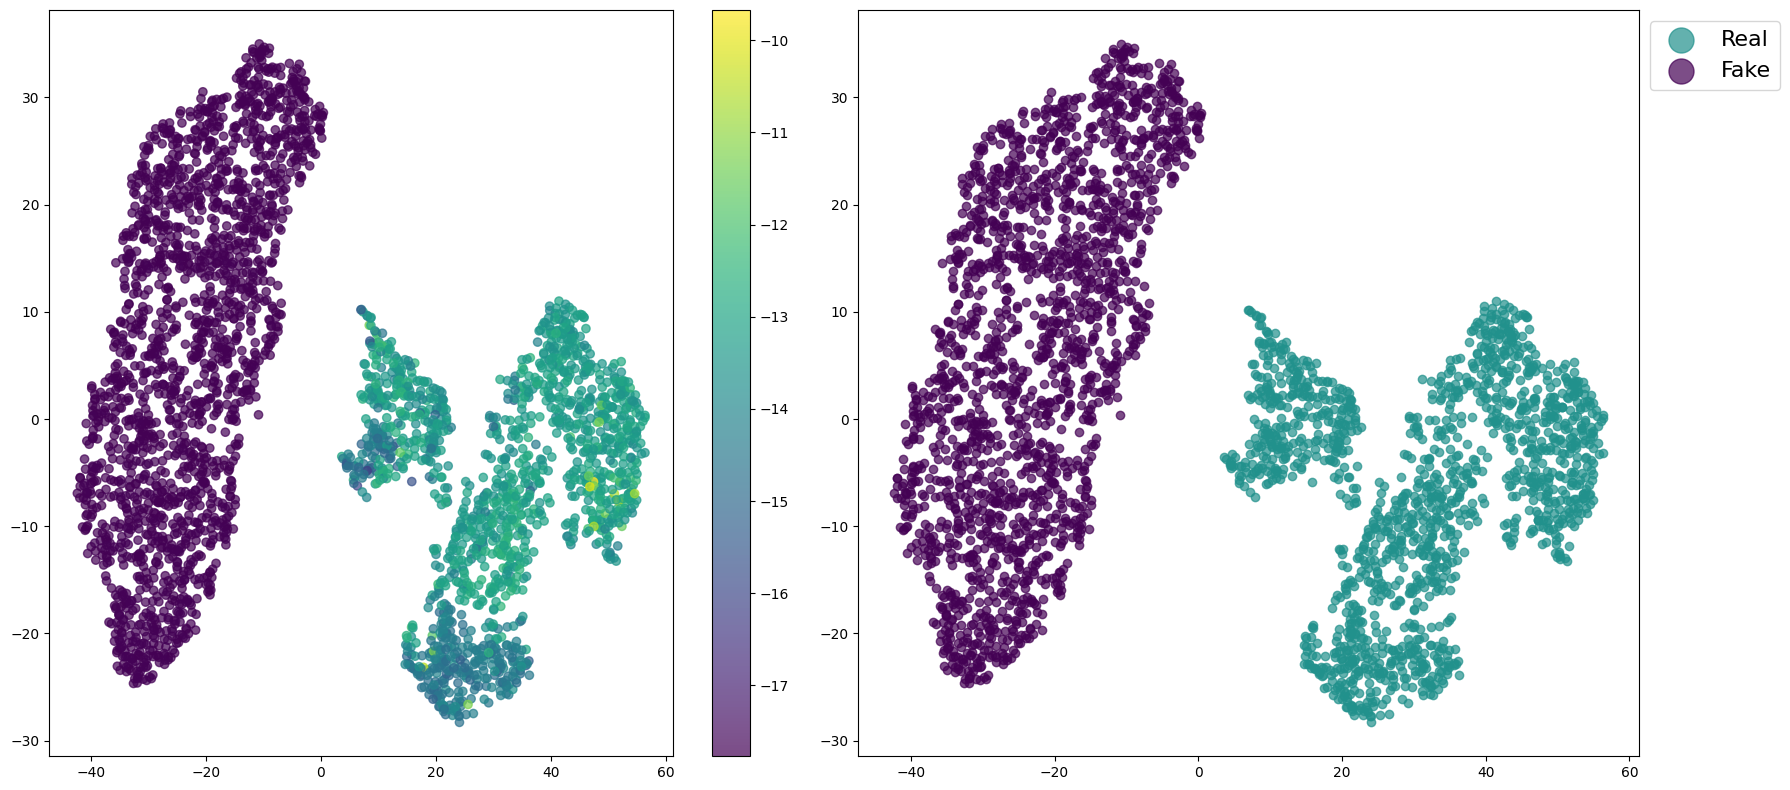

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
ax = axes[0]
scatter1 = ax.scatter(reduced[:, 0], reduced[:, 1], c=np.concatenate((labels, labels_fake)), cmap='viridis', alpha=0.7)
cbar = plt.colorbar(scatter1, ax=ax) 


ax = axes[1]
rf = np.squeeze(np.concatenate((np.full_like(labels, '1'), np.full_like(labels_fake, '0'))))
scatter_real = ax.scatter(
    reduced[rf == 1, 0],  
    reduced[rf == 1, 1],
    c= plt.cm.viridis([0.5]),
    label='Real',
    alpha=0.7
)

scatter_fake = ax.scatter(
    reduced[rf == 0, 0],  
    reduced[rf == 0, 1],
    c=plt.cm.viridis([0.0]),
    label='Fake',
    alpha=0.7
)
# ax.legend()
ax.legend(fontsize=16, markerscale=3, bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../imgs/compl_disc.png')
plt.show()


In [33]:
df = df_olga.copy()
df2 = df_real.copy()

In [34]:
df['seq_enc'] = df['b_cdr3aa'].apply(encode_seq)
df['label'] = 0
df = df.rename(columns = {'b_cdr3aa': 'cdr3aa'})

In [35]:
df2 = pd.DataFrame(random.choices(seqs_df.cdr3aa, k = 500), columns = ['cdr3aa'])
df2['seq_enc'] = df2['cdr3aa'].apply(encode_seq)
df2['label'] = 1
df2.head()

,cdr3aa,seq_enc,label
0,CASSLPSGGGNEQFF,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1
1,CASSPPTGKGSPLHF,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1
2,CASSFLGSGSTDAFF,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1
3,CASSRRTGEGDTQYF,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1
4,CASSPEAGGTSPLHF,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1


In [36]:
big_df = pd.concat([df, df2]).reset_index(drop=True)
big_df

,cdr3aa,pgen_log,seq_enc,label
0,CARETLKGGNSPLHF,-12.16173,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0
1,CAEGNYGYSNQPQHF,-11.80578,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0
2,CASSFSIRGFETQYF,-10.25370,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0
3,CSAFGGGGDGSPLHF,-12.38396,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0
4,CASSQKNISTDTQYF,-10.02048,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0
...,...,...,...,...
995,CASSEVQGHTGELFF,NaN,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1
996,CASSSPQGFYNEQFF,NaN,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1
997,CASSAQGGVTGELFF,NaN,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1
998,CASSLSLGPNYGYTF,NaN,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1


In [37]:
imgs = torch.tensor(big_df['seq_enc'].tolist(), dtype=torch.float32)
# imgs_с = torch.tensor(df2['seq_enc'].tolist(), dtype=torch.float32)

# labels_o = df['label'].tolist()
# labels = df2['label'].tolist()

In [38]:
discriminator = to_device(discriminator, device)
discriminator_c = to_device(discriminator_c, device)

In [39]:
feature_extractor_o = torch.nn.Sequential(*list(discriminator.children())[:-3])
feature_extractor = torch.nn.Sequential(*list(discriminator_c.children())[:-3])


In [40]:
from sklearn.manifold import TSNE


In [52]:
imgs = imgs.to(device)
# imgs_o = imgs_o.to(device)


with torch.no_grad():
    latent_vectors_o = feature_extractor_o(imgs).cpu().numpy()
    latent_vectors = feature_extractor(imgs).cpu().numpy()


reduced_all = TSNE(n_components=2, perplexity=50, metric = 'correlation', random_state=42, verbose=0).fit_transform(np.concatenate((latent_vectors_o, latent_vectors)))

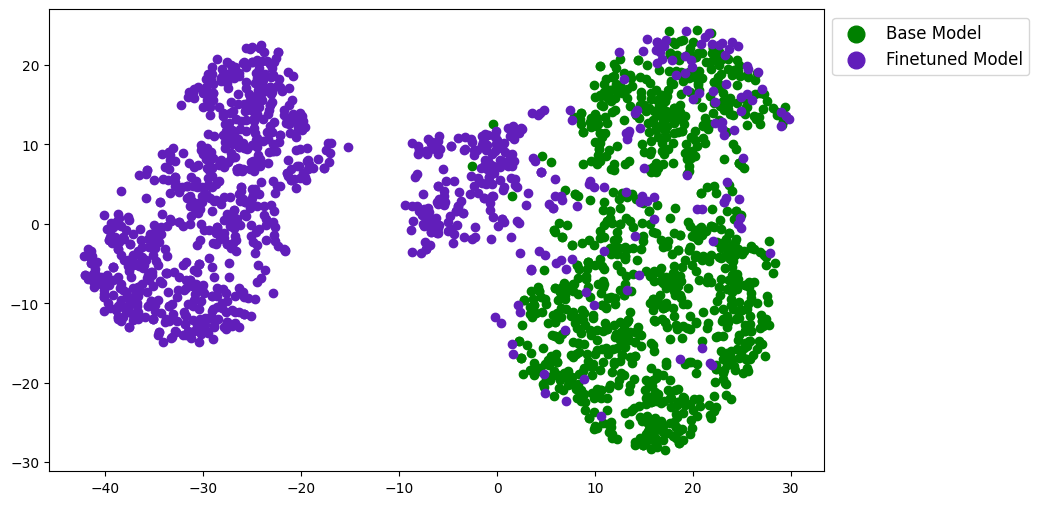

In [57]:

# reduced = TSNE(n_components=2, random_state=42, verbose=0).fit_transform(latent_vectors)
reduced_o = reduced_all[:latent_vectors_o.shape[0]]
reduced = reduced_all[latent_vectors_o.shape[0]:]

# labels_o = np.array(labels_o)
# labels = np.array(labels)

colors = ["red", "green"]
labels_map = {0: "OLGA", 1: "FMBA"}

plt.figure(figsize=(10, 6))

plt.scatter(reduced_o[:, 0], reduced_o[:, 1], color='green', label='Base Model')
plt.scatter(reduced[:, 0], reduced[:, 1], color='#611eba', label='Finetuned Model')

plt.legend(fontsize=12, markerscale=2, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


In [55]:
from scipy import stats
stats.pearsonr(latent_vectors.ravel(), latent_vectors_o.ravel())

PearsonRResult(statistic=0.9817580857724831, pvalue=0.0)

In [207]:
fake_images = []
generator_c = to_device(generator_c, device)
generator = to_device(generator, device)

for i in range(10):
    latent = torch.rand(64, latent_size, 1, 1, device=device) * 2 - 1
    fake_images.extend(generator_c(latent).cpu().detach().numpy())
    fake_images.extend(generator(latent).cpu().detach().numpy())
    
fake_images = torch.FloatTensor(fake_images)
fake_images.shape


torch.Size([1280, 10, 15, 20])

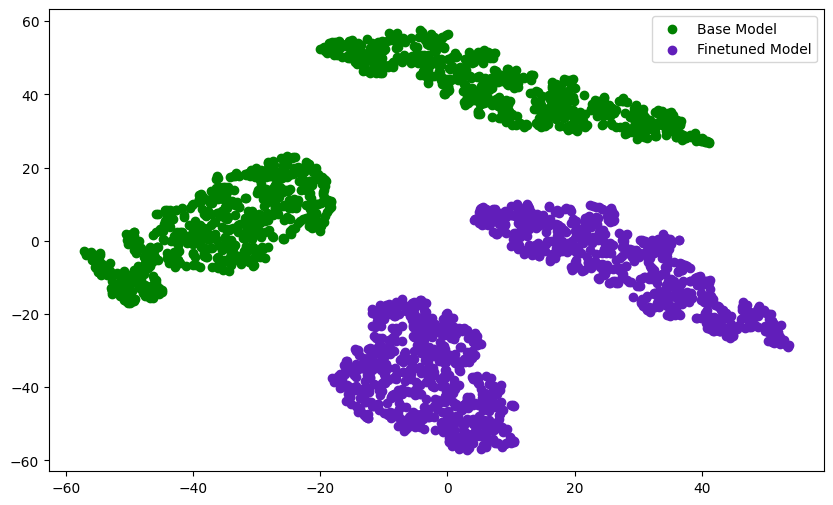

In [209]:
fake_images = fake_images.to(device)


with torch.no_grad():
    latent_vectors_o = feature_extractor_o(fake_images).cpu().numpy()
    latent_vectors = feature_extractor(fake_images).cpu().numpy()

reduced_all = TSNE(n_components=2, random_state=42, verbose=0).fit_transform(np.concatenate((latent_vectors_o, latent_vectors)))

reduced_o = reduced_all[:latent_vectors_o.shape[0]]
reduced = reduced_all[latent_vectors_o.shape[0]:]

plt.figure(figsize=(10, 6))

plt.scatter(reduced_o[:, 0], reduced_o[:, 1], color='green', label='Base Model')
plt.scatter(reduced[:, 0], reduced[:, 1], color='#611eba', label='Finetuned Model')

plt.legend()
plt.show()

In [210]:
fake_images = []
generator_c = to_device(generator_c, device)
for i in range(60):
    latent = torch.rand(batch_size, latent_size, 1, 1, device=device) * 2 - 1
    fake_images.extend(generator_c(latent).cpu().detach().numpy())
    
fake_images = torch.FloatTensor(fake_images)
fake_images.shape


torch.Size([3840, 10, 15, 20])

## Latent space of generator

In [214]:
class GeneratorWrapper(nn.Module):
    def __init__(self, generator):
        super(GeneratorWrapper, self).__init__()
        self.generator = generator
        self.last_conv_layer = None
        for layer in reversed(list(generator.children())):
            if isinstance(layer, nn.ConvTranspose2d):
                self.last_conv_layer = layer
                break

    def forward(self, x):
        activations = x
        for layer in list(self.generator.children()):
            activations = layer(activations)
            if layer == self.last_conv_layer:
                break

        output = self.generator(x)
        return activations, output

In [196]:
generator_wrapper_o = GeneratorWrapper(generator)

activations = []
for i in range(30):
    latent = torch.rand(batch_size, latent_size, 1, 1, device=device) * 2 - 1
    with torch.no_grad():
        activations_batch, _ = generator_wrapper_o(latent)
        activations.append(activations_batch.cpu().numpy())

activations = np.concatenate(activations, axis=0)
activations.shape

(1920, 10, 15, 20)

In [218]:
order = aa_inds['f1']

def reorder_aa(activation, real_order, ref_order=order):
    ref_order = ref_order.values
    real_order = real_order.values

    reordered = pd.DataFrame(activation, columns = real_order)
    reordered = reordered[ref_order]
        
    return reordered

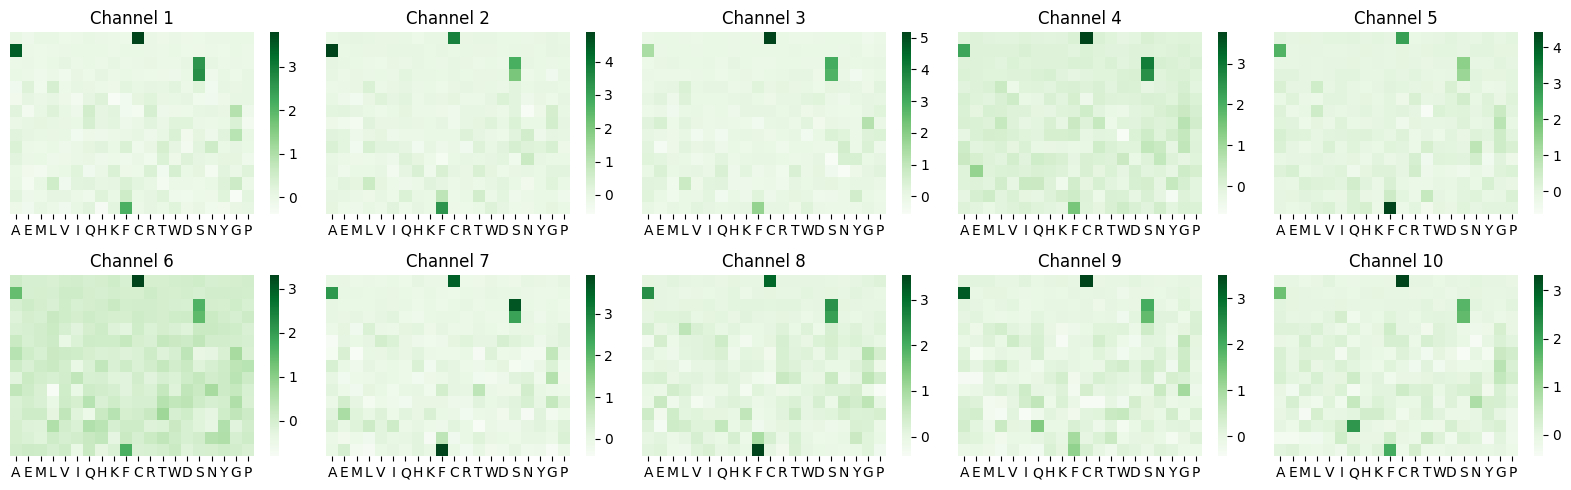

In [95]:
sample_activations = activations[0]  
num_channels = sample_activations.shape[0]

plt.figure(figsize=(16, 5)) 
for i in range(num_channels):
    reordered = reorder_aa(sample_activations[i], aa_inds[f'f{i+1}'], aa_inds['f1'])

    
    plt.subplot(2, 5, i + 1)
    x_labels = aa_inds['f1']
    sns.heatmap(reordered, cmap='Greens', cbar=True, xticklabels=x_labels, yticklabels=False)
    plt.xticks(rotation=0),
    plt.title(f"Channel {i + 1}")
plt.tight_layout(),
plt.savefig('/home/akabalina/nlp_tcr_predictor/diploma/imgs/FCNN/hid_l_base.png')
plt.show()

In [220]:
generator_wrapper_o = GeneratorWrapper(generator_c)

activations = []
for i in range(15):
    latent = torch.rand(batch_size, latent_size, 1, 1, device=device) * 2 - 1
    with torch.no_grad():
        activations_batch, _ = generator_wrapper_o(latent)
        activations.append(activations_batch.cpu().numpy())

activations = np.concatenate(activations, axis=0)
activations.shape

(960, 10, 15, 20)

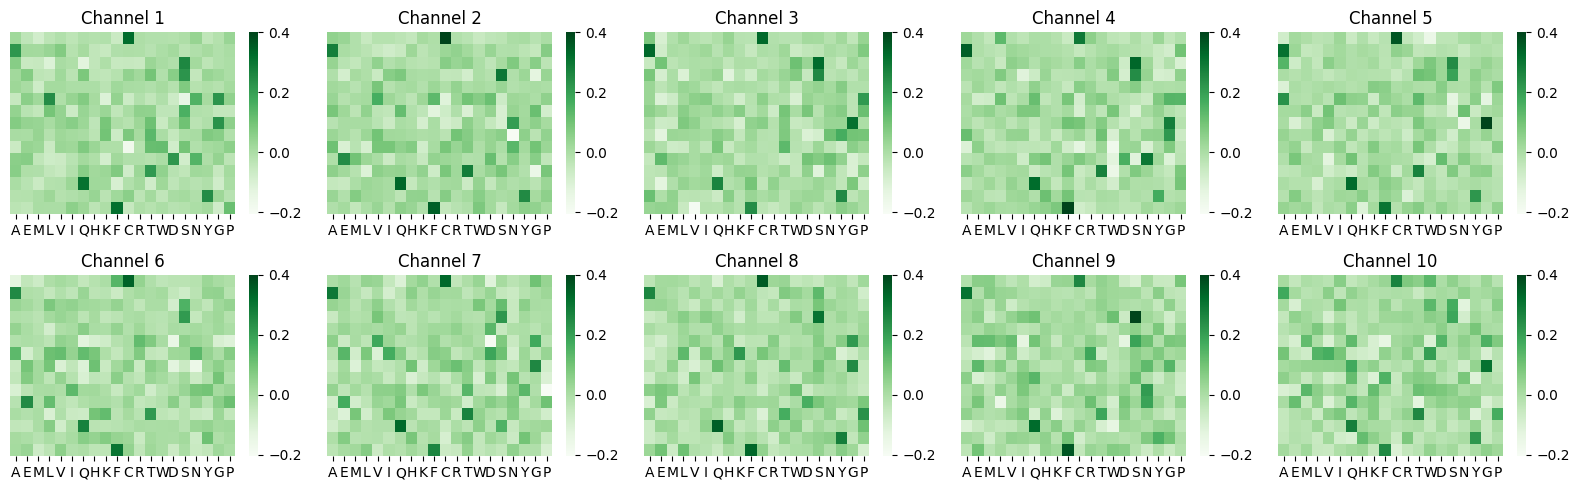

In [201]:
sample_activations = activations[0]  
num_channels = sample_activations.shape[0]
global_min = min([sample_activations[i].min() for i in range(num_channels)])
global_max = max([sample_activations[i].max() for i in range(num_channels)])

plt.figure(figsize=(16, 5)) 
for i in range(num_channels):
    reordered = reorder_aa(sample_activations[i], aa_inds[f'f{i+1}'], aa_inds['f1'])

    
    plt.subplot(2, 5, i + 1)
    x_labels = aa_inds['f1']
    sns.heatmap(reordered, cmap='Greens', cbar=True, xticklabels=x_labels, yticklabels=False, vmin=global_min, vmax=0.4)
    plt.xticks(rotation=0),
    plt.title(f"Channel {i + 1}")
plt.tight_layout(),
# plt.savefig('/home/akabalina/nlp_tcr_predictor/diploma/imgs/hid_l_cov30.png')
plt.show()

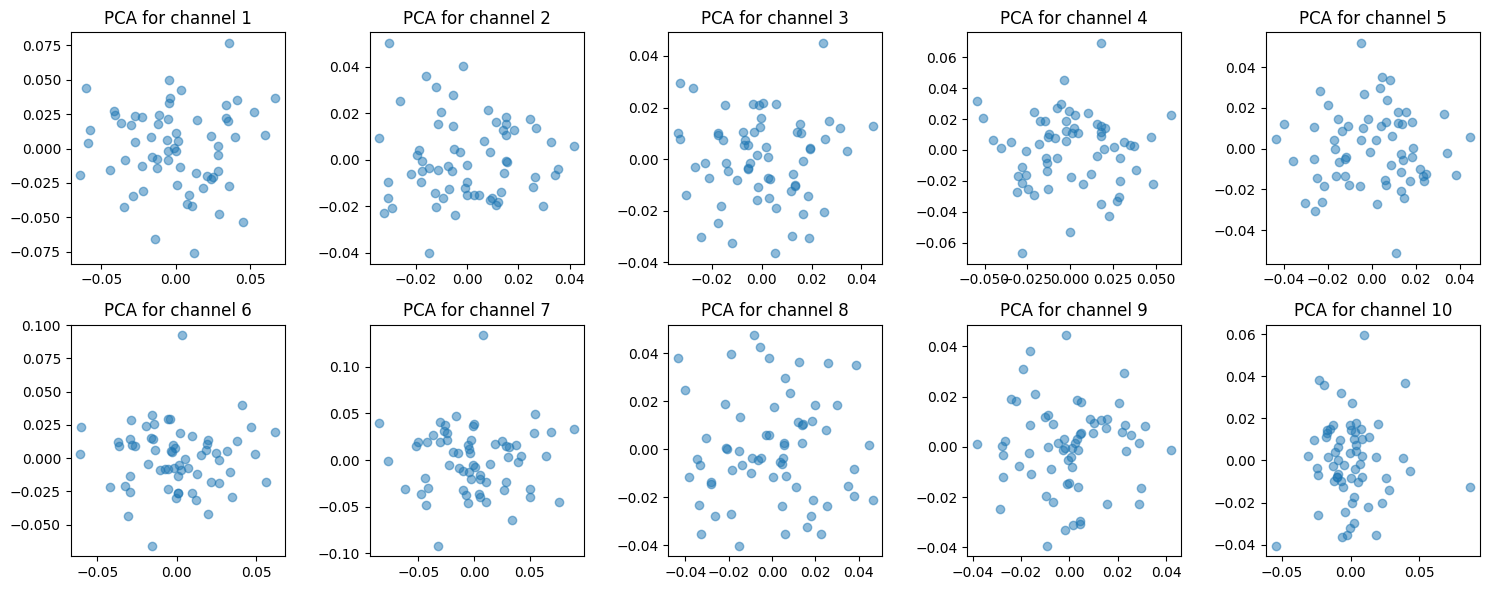

In [228]:
from sklearn.decomposition import PCA
pca_results = []

num_channels = 10
for channel in range(num_channels):
    channel_data = activations[:, :, :, channel]
    channel_data_flat = channel_data.reshape(batch_size, -1)  # [batch_size, 15*20]
    
    pca = PCA(n_components=2)
    channel_pca = pca.fit_transform(channel_data_flat)
    pca_results.append(channel_pca)

plt.figure(figsize=(15, 6))
for channel in range(num_channels):
    plt.subplot(2, 5, channel + 1) 
    plt.scatter(pca_results[channel][:, 0], pca_results[channel][:, 1], alpha=0.5)
    plt.title(f"PCA for channel {channel + 1}")
plt.tight_layout()
plt.show()